In [ ]:
# Code for the Book: International Stock Picking A.I. INVESTOR: A Guide to Build.
# Website: ai-investor.net
# Code needs am "All-In-One" subscription from the (presumably) nice people at https://eodhistoricaldata.com/. 
# Check the book text to see if they have changed their service since mid-2021.

# Damon Lee 2021

# Feel free to fork this code for others to see what can be done with it.

In [ ]:
myToken = 'ABC123.XXXXXX.84098767' # Own token from EODHistoricalData

In [2]:
import pandas as pd
import numpy as np
import requests

# Set the plotting DPI settings to be a bit higher.
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

from myFunctions import *

# Load X and y

In [3]:
X=pd.read_csv('filteredAnnualStockFeatures_2021.csv', index_col=0)
y=pd.read_csv('filteredAnnualStockPerformance_2021.csv', index_col=0)

In [4]:
# randomize the rows
X['y'] = y
X = X.sample(frac=1.0, random_state=42) # randomize the rows
y = X['y']
X.drop(columns=['y'], inplace=True)

# Create the models
Make functions for the models we will call in testing.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

lin_regr = Pipeline([('powerTransformer', PowerTransformer()), 
                     ('Enet', ElasticNet(random_state=42))])

rf_regr = RandomForestRegressor(random_state=42, max_depth=30)

ert_regr = ExtraTreesRegressor(random_state=42, n_estimators=100, max_depth=30)

gbst_regr = GradientBoostingRegressor(random_state=42)

knn_regr = Pipeline([('powerTransformer', PowerTransformer()), 
                     ('knn', KNeighborsRegressor(n_neighbors=40))])

svm_regr = Pipeline([('powerTransformer', PowerTransformer()), 
                     ('svr', SVR())])

# Classic Machine Learning Performance Measures
Try all models with CV, etc. Validation and learning curves to know roughly where it is overfitting (as can't judge this when measuring performance)

In [6]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit

def cvValidCurvesScores(regressor, featureToValidate, feature_range, X, y):
    '''
    Runs sklearn validation_curve(s) for a regressor, scoring is RMSE.
    Returns a DataFrame of mean train/test scores and their std. devs.
    '''
    featureDict = {'param_name':featureToValidate,
                   'param_range':feature_range}
    
    train_scores, valid_scores = \
    validation_curve(regressor, X,
                     np.array(y).ravel(), 
                     **featureDict,
                     cv=ShuffleSplit(n_splits=10,
                                     test_size=0.2,
                                     random_state=42),
                     scoring='neg_mean_squared_error',
                     n_jobs=16)
    
    df = pd.DataFrame(index=feature_range)
    df['train_scores_mean'] = np.sqrt(-np.mean(train_scores, axis=1))
    df['train_scores_std'] = np.std(np.sqrt(-train_scores), axis=1)
    df['test_scores_mean'] = np.sqrt(-np.mean(valid_scores, axis=1))
    df['test_scores_std'] = np.std(np.sqrt(-valid_scores), axis=1)
    return df

In [7]:
from sklearn.model_selection import learning_curve
def cvLearnCurvesScores(regressor, X, y):
    '''
    Runs sklearn learning_curve(s) for a regressor, scoring is RMSE.
    Runs in parallel 4 cores.
    Returns a DataFrame of mean train/test scores and their std. devs.
    '''
    sizesToTrain = [0.0005, 0.001, 0.01, 0.1, 0.2, 0.5]   
    
    train_sizes, train_scores, test_scores, fit_times, score_times = \
        learning_curve(regressor, X, y, cv=ShuffleSplit(n_splits=10,
                                                    test_size=0.2,
                                                    random_state=42),
                       scoring='neg_mean_squared_error',\
                       n_jobs=16, train_sizes=sizesToTrain,\
                       return_times=True)
    
    df = pd.DataFrame(index=train_sizes)
    df['train_scores_mean'] = np.sqrt(-np.mean(train_scores, axis=1))
    df['train_scores_std'] = np.std(np.sqrt(-train_scores), axis=1)
    df['test_scores_mean'] = np.sqrt(-np.mean(test_scores, axis=1))
    df['test_scores_std'] = np.std(np.sqrt(-test_scores), axis=1)
    df['fit_times_mean'] = np.mean(fit_times, axis=1)
    df['fit_times_std'] = np.std(fit_times, axis=1)
    return df

In [8]:
def plotCurves(df, title, xAxis='Number of Training Rows'):
    '''
    Plots learning curves. 
    Input is DataFrame from cvLearnCurvesScores or cvValidCurvesScores.
    '''
    df['train_scores_mean'].plot(style='-x')
    df['test_scores_mean'].plot(style='-o')

    plt.fill_between(df.index,\
                     df['train_scores_mean']-df['train_scores_std'],\
                     df['train_scores_mean']+df['train_scores_std'], alpha=0.2)
    plt.fill_between(df.index,\
                     df['test_scores_mean']-df['test_scores_std'],\
                     df['test_scores_mean']+df['test_scores_std'], alpha=0.2)
    plt.grid()
    plt.legend(['Training CV RMSE Score','Test Set RMSE'])
    plt.ylabel('RMSE')
    plt.xlabel(xAxis)
    plt.title(title)

# Validation Curves for Some Models

### Linear Regression

In [14]:
lin_regr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'powerTransformer', 'Enet', 'powerTransformer__copy', 'powerTransformer__method', 'powerTransformer__standardize', 'Enet__alpha', 'Enet__copy_X', 'Enet__fit_intercept', 'Enet__l1_ratio', 'Enet__max_iter', 'Enet__normalize', 'Enet__positive', 'Enet__precompute', 'Enet__random_state', 'Enet__selection', 'Enet__tol', 'Enet__warm_start'])

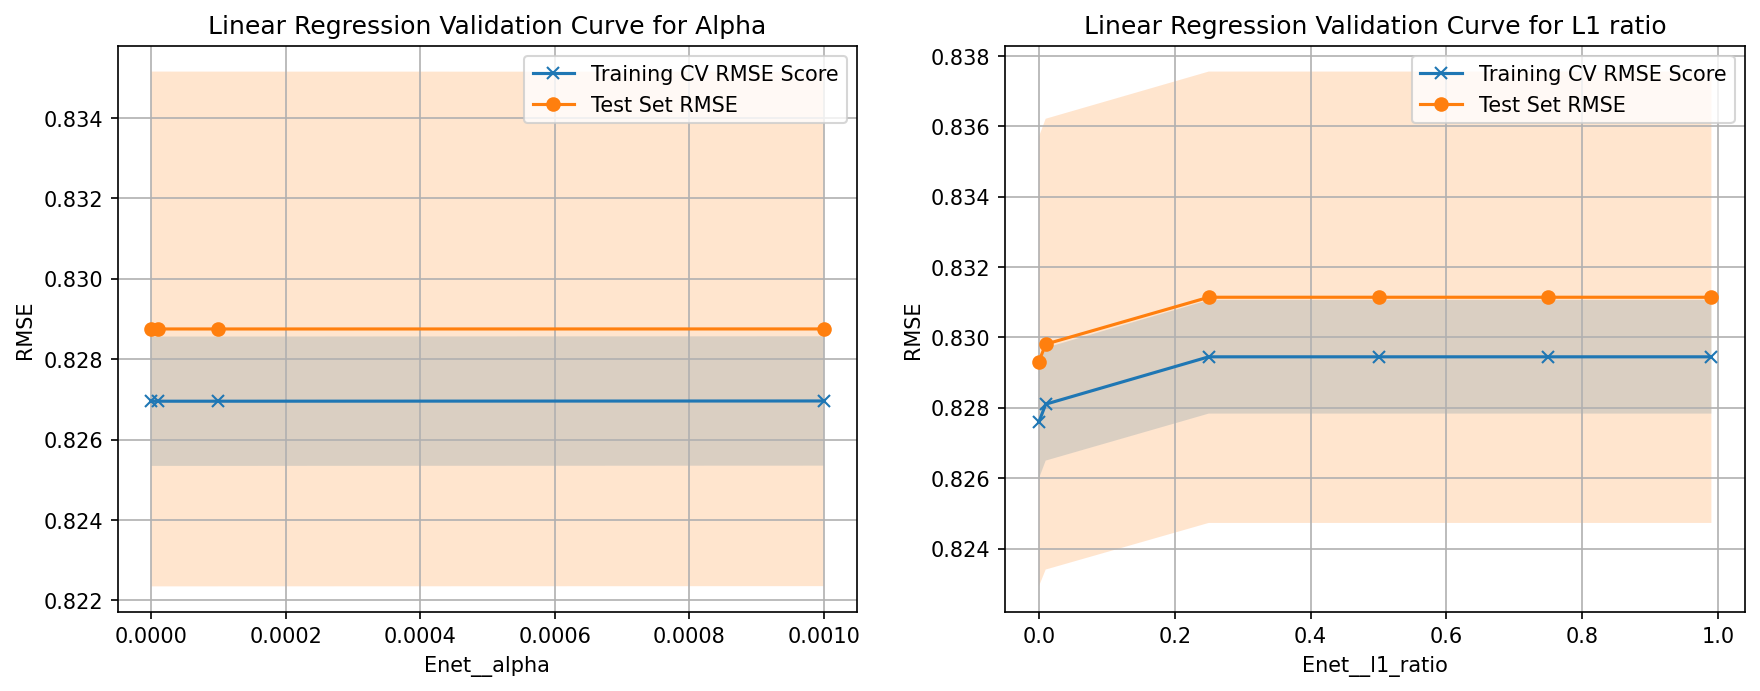

In [37]:
lin_valid_a_df = cvValidCurvesScores(lin_regr, 'Enet__alpha', np.array([0, 1e-5, 1e-4, 1e-3]), X, y)
lin_valid_l1_df = cvValidCurvesScores(lin_regr, 'Enet__l1_ratio', np.array([0, 0.01, 0.25, 0.5, 0.75, 0.99]), X, y)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plotCurves(lin_valid_a_df, 'Linear Regression Validation Curve for Alpha', xAxis='Enet__alpha')
plt.subplot(1,2,2)
plotCurves(lin_valid_l1_df, 'Linear Regression Validation Curve for L1 ratio', xAxis='Enet__l1_ratio')
# Conclusion: Basically doesn't matter because it doesn't learn.

### KNN

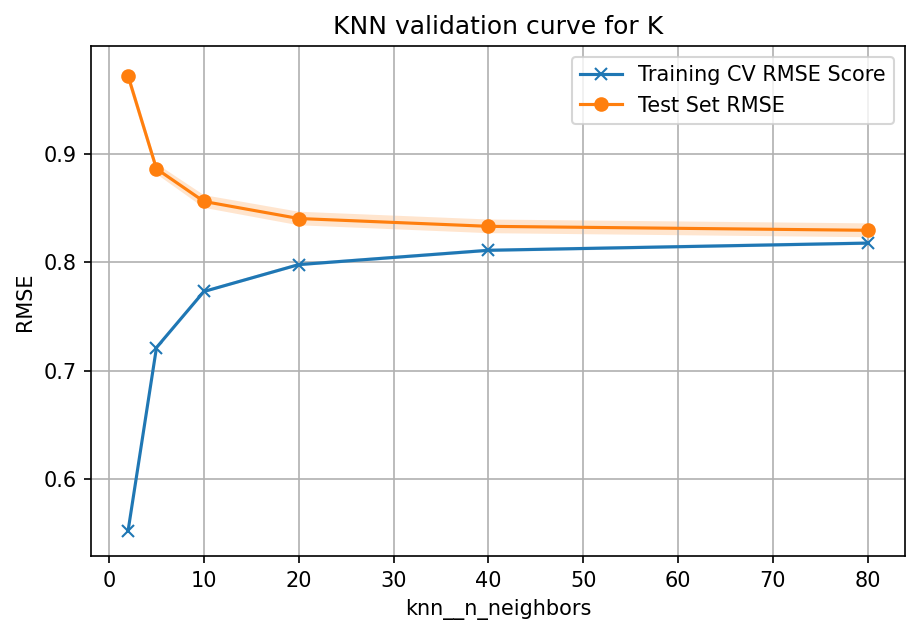

In [16]:
# Takes a very long time.
knn_valid_df = cvValidCurvesScores(knn_regr, 
                                   'knn__n_neighbors', 
                                   np.array([2, 5, 10, 20, 40, 80]), 
                                   X, y)
plotCurves(knn_valid_df, 'KNN validation curve for K', xAxis='knn__n_neighbors')
# Conclusion: 20 to 40 is OK

### Simpler Tree-based Predictors

In [26]:
rf_regr.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [18]:
rf_valid_df = cvValidCurvesScores(rf_regr, 
                                  'max_depth', 
                                  np.array([2, 7, 15, 30]), 
                                  X, y)

ert_valid_df = cvValidCurvesScores(ert_regr, 
                                   'max_depth', 
                                   np.array([2, 7, 15, 30]), 
                                   X, y)

gbst_valid_df = cvValidCurvesScores(gbst_regr, 
                                    'max_depth', 
                                    np.array([2, 7, 15, 30]), 
                                    X, y)

In [19]:
rf_valid_df.to_csv('rf_valid_df.csv')
ert_valid_df.to_csv('ert_valid_df.csv')
gbst_valid_df.to_csv('gbst_valid_df.csv')

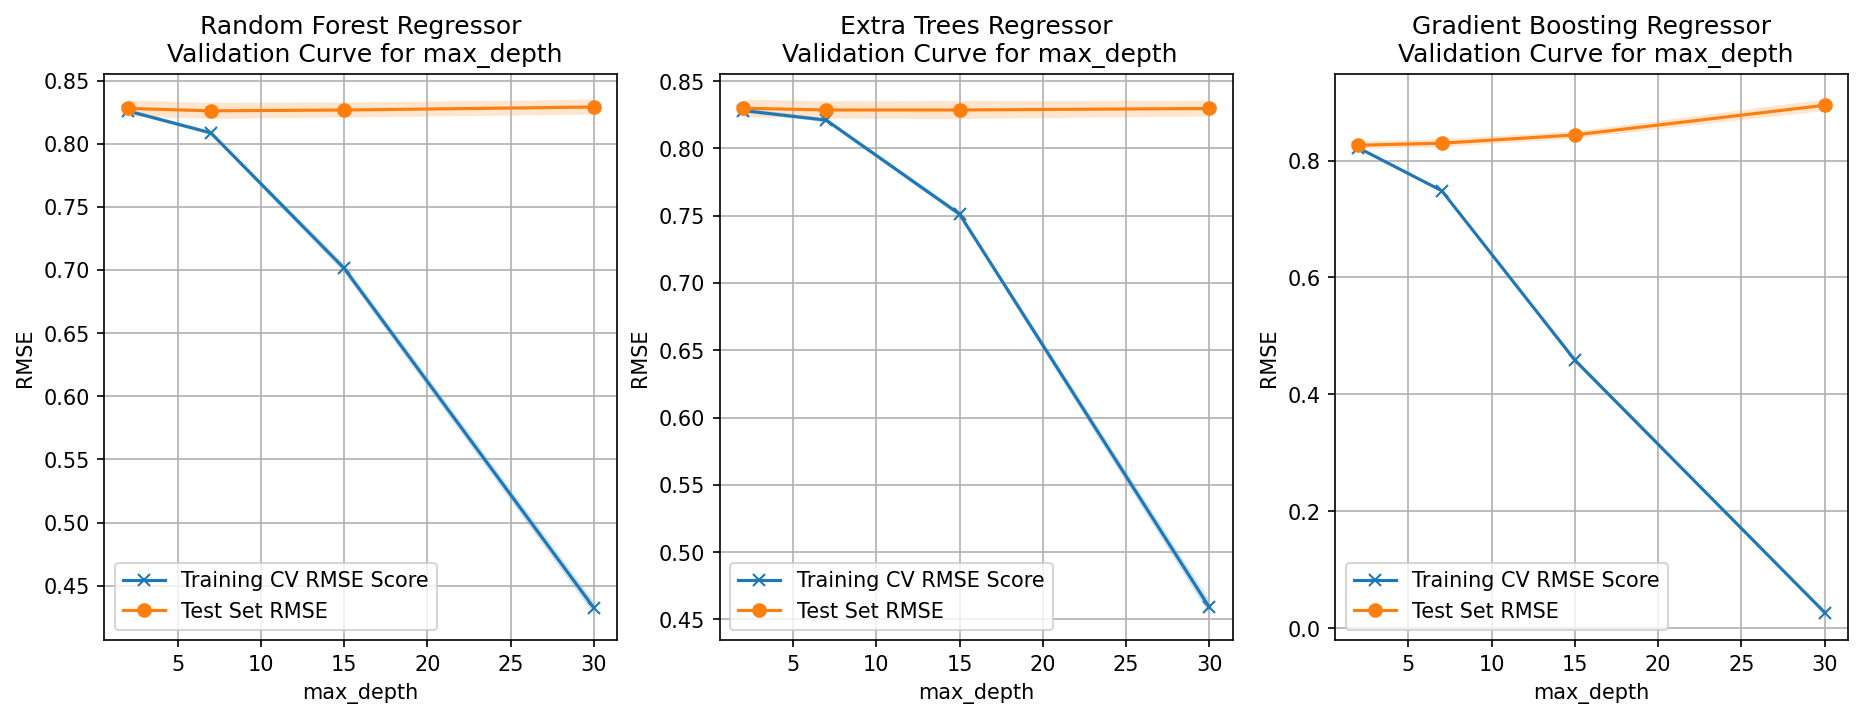

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plotCurves(rf_valid_df, 
           'Random Forest Regressor\n Validation Curve for max_depth', 
           xAxis='max_depth')
plt.subplot(1,3,2)
plotCurves(ert_valid_df, 
           'Extra Trees Regressor\n Validation Curve for max_depth', 
           xAxis='max_depth')
plt.subplot(1,3,3)
plotCurves(gbst_valid_df, 
           'Gradient Boosting Regressor\n Validation Curve for max_depth',
           xAxis='max_depth')
# Conclusion: Depends how OK you are with overfitting.

In [33]:
rf_valid_df = cvValidCurvesScores(rf_regr, 
                                  'n_estimators', 
                                  np.array([2, 7, 15, 30, 100, 200]), 
                                  X, y)

ert_valid_df = cvValidCurvesScores(ert_regr, 
                                   'n_estimators', 
                                   np.array([2, 7, 15, 30, 100, 200]), 
                                   X, y)

gbst_valid_df = cvValidCurvesScores(gbst_regr, 
                                    'n_estimators', 
                                    np.array([2, 7, 15, 30, 100, 200]), 
                                    X, y)

In [34]:
rf_valid_df.to_csv('rf_valid_nEstimators_df.csv')
ert_valid_df.to_csv('ert_valid_nEstimators_df.csv')
gbst_valid_df.to_csv('gbst_valid_nEstimators_df.csv')

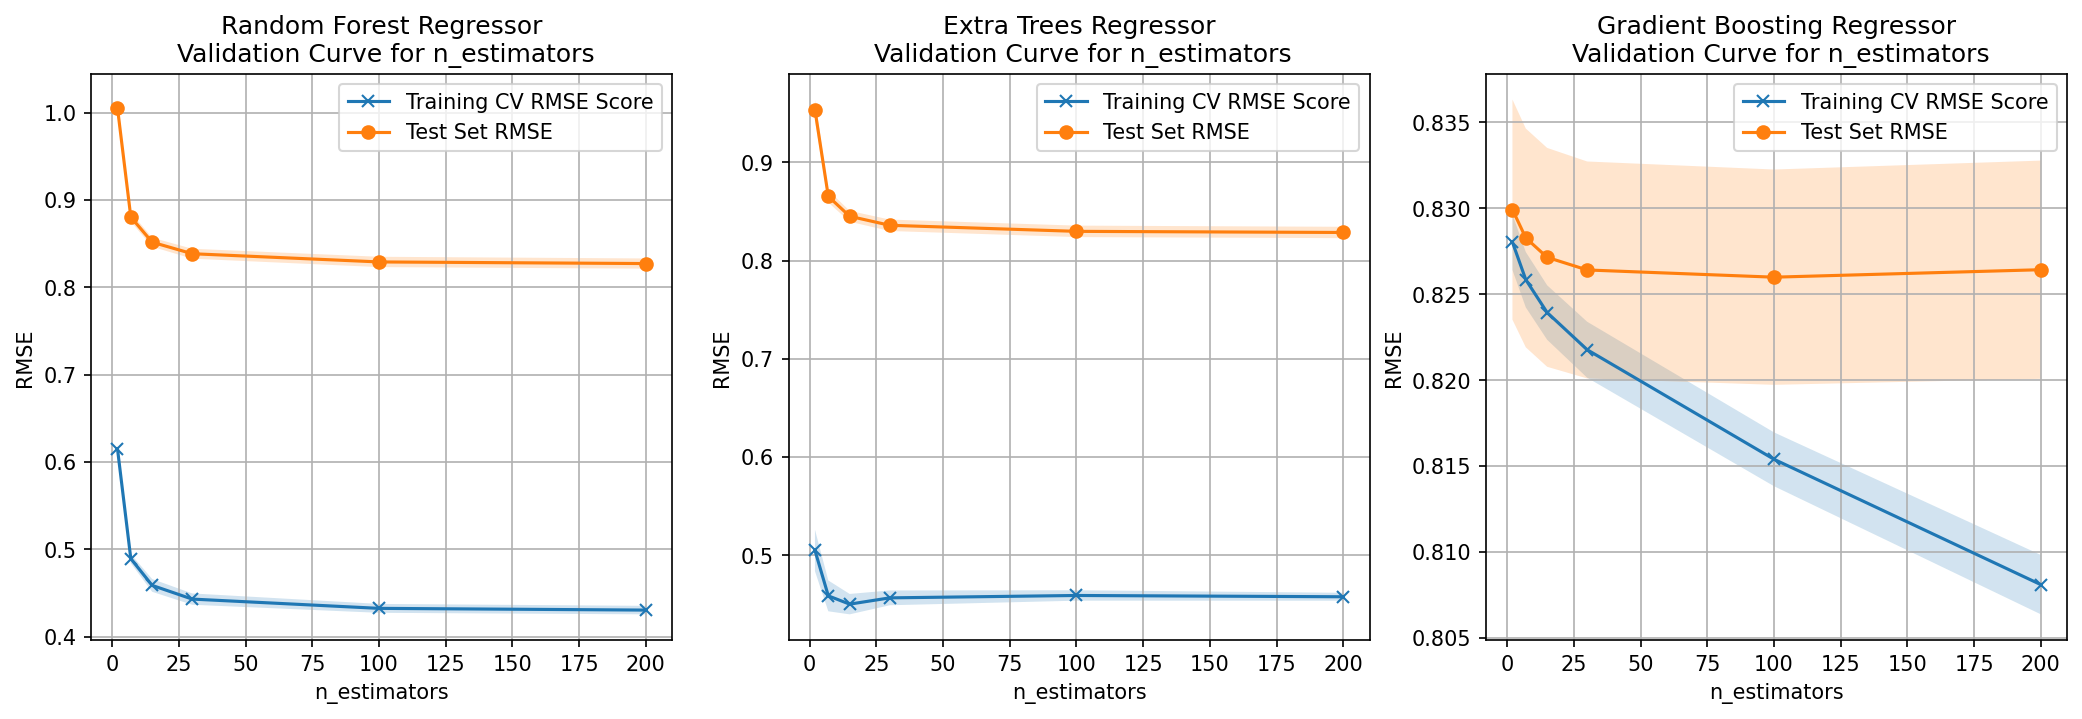

In [42]:
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plotCurves(rf_valid_df, 
           'Random Forest Regressor\n Validation Curve for n_estimators', 
           xAxis='n_estimators')
plt.subplot(1,3,2)
plotCurves(ert_valid_df, 
           'Extra Trees Regressor\n Validation Curve for n_estimators', 
           xAxis='n_estimators')
plt.subplot(1,3,3)
plotCurves(gbst_valid_df, 
           'Gradient Boosting Regressor\n Validation Curve for n_estimators',
           xAxis='n_estimators')

# Learning Curves For Models

### Linear Regression(regularised) and SVR

In [44]:
lin_df = cvLearnCurvesScores(lin_regr, X, y)
svr_df = cvLearnCurvesScores(svm_regr, X, y)

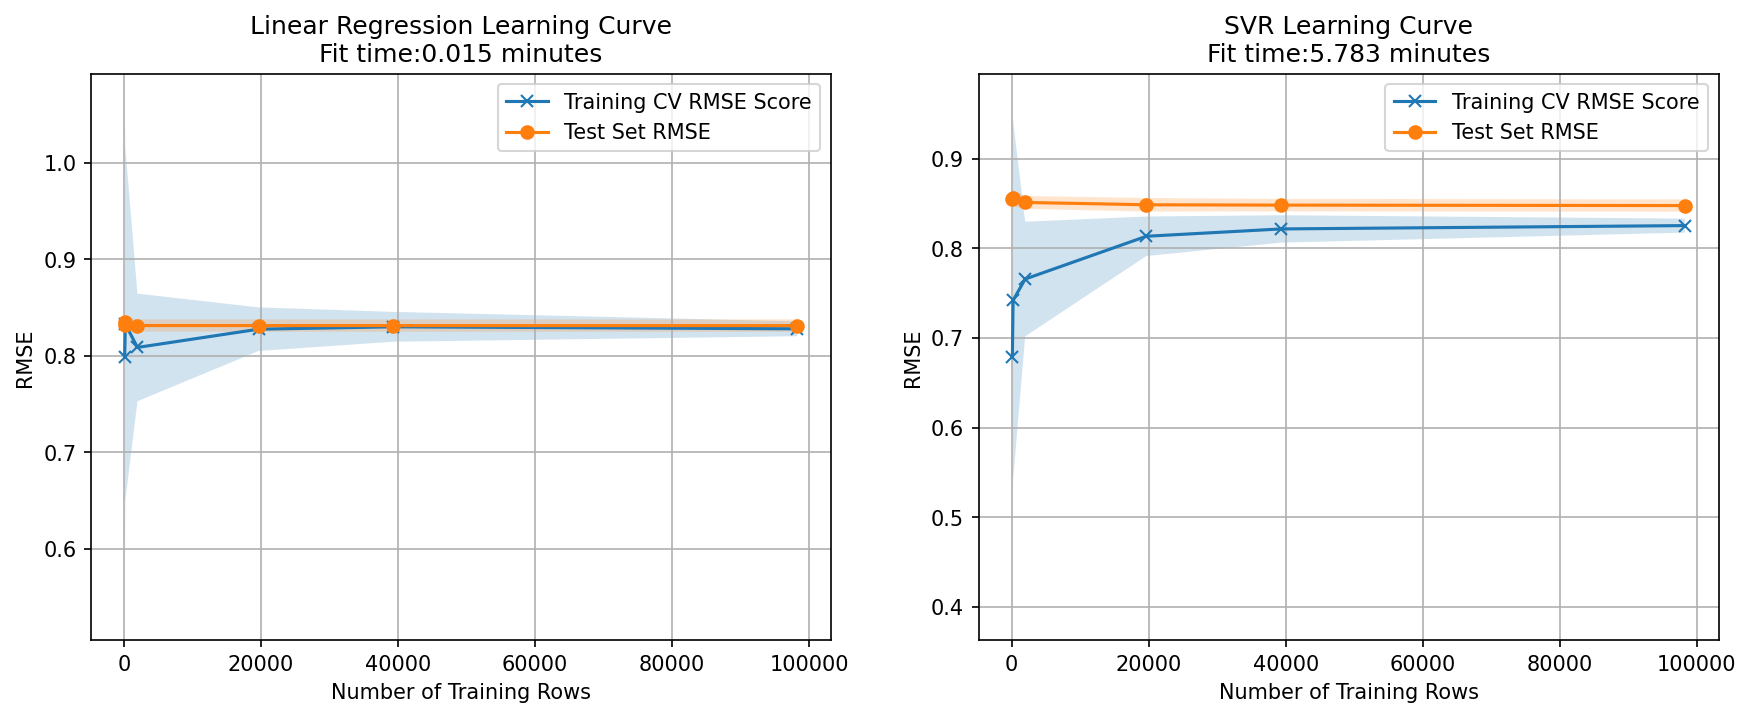

In [45]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plotCurves(lin_df, 'Linear Regression Learning Curve\nFit time:'+str(round(lin_df['fit_times_mean'].mean()/60,3))+' minutes')
plt.subplot(1,2,2)
plotCurves(svr_df, 'SVR Learning Curve\nFit time:'+str(round(svr_df['fit_times_mean'].mean()/60,3))+' minutes')

### KNN

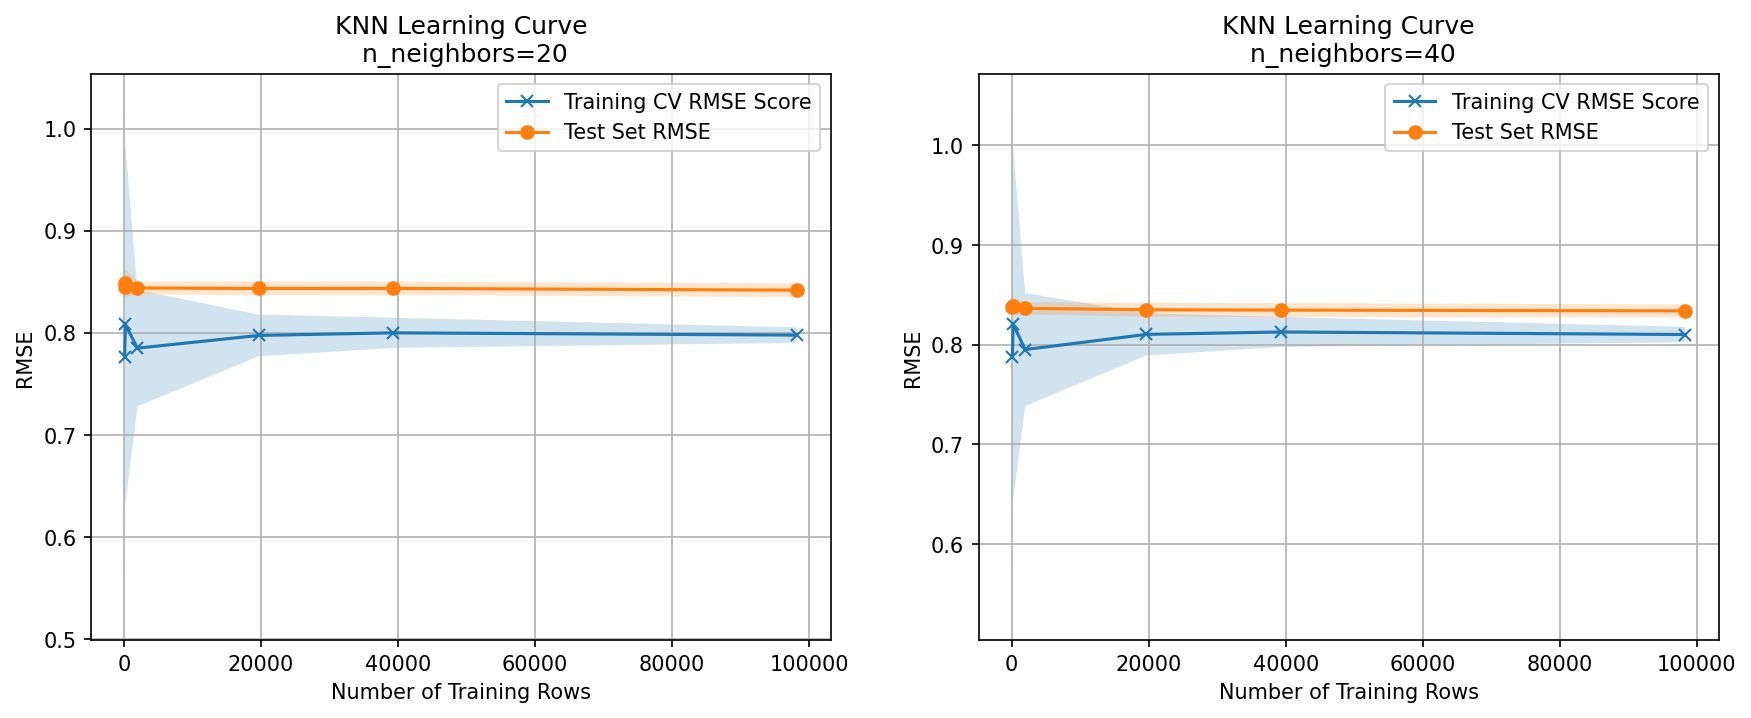

In [46]:
knn_regr = Pipeline([('powerTransformer', PowerTransformer()), ('knn', KNeighborsRegressor(n_neighbors=20))])
knn_df1 = cvLearnCurvesScores(knn_regr, X, y)
knn_regr = Pipeline([('powerTransformer', PowerTransformer()), ('knn', KNeighborsRegressor(n_neighbors=40))])
knn_df2 = cvLearnCurvesScores(knn_regr, X, y)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plotCurves(knn_df1,'KNN Learning Curve\n n_neighbors=20')
plt.subplot(1,2,2)
plotCurves(knn_df2,'KNN Learning Curve\n n_neighbors=40')

### Random Forest, ExtraTrees and Gradboost

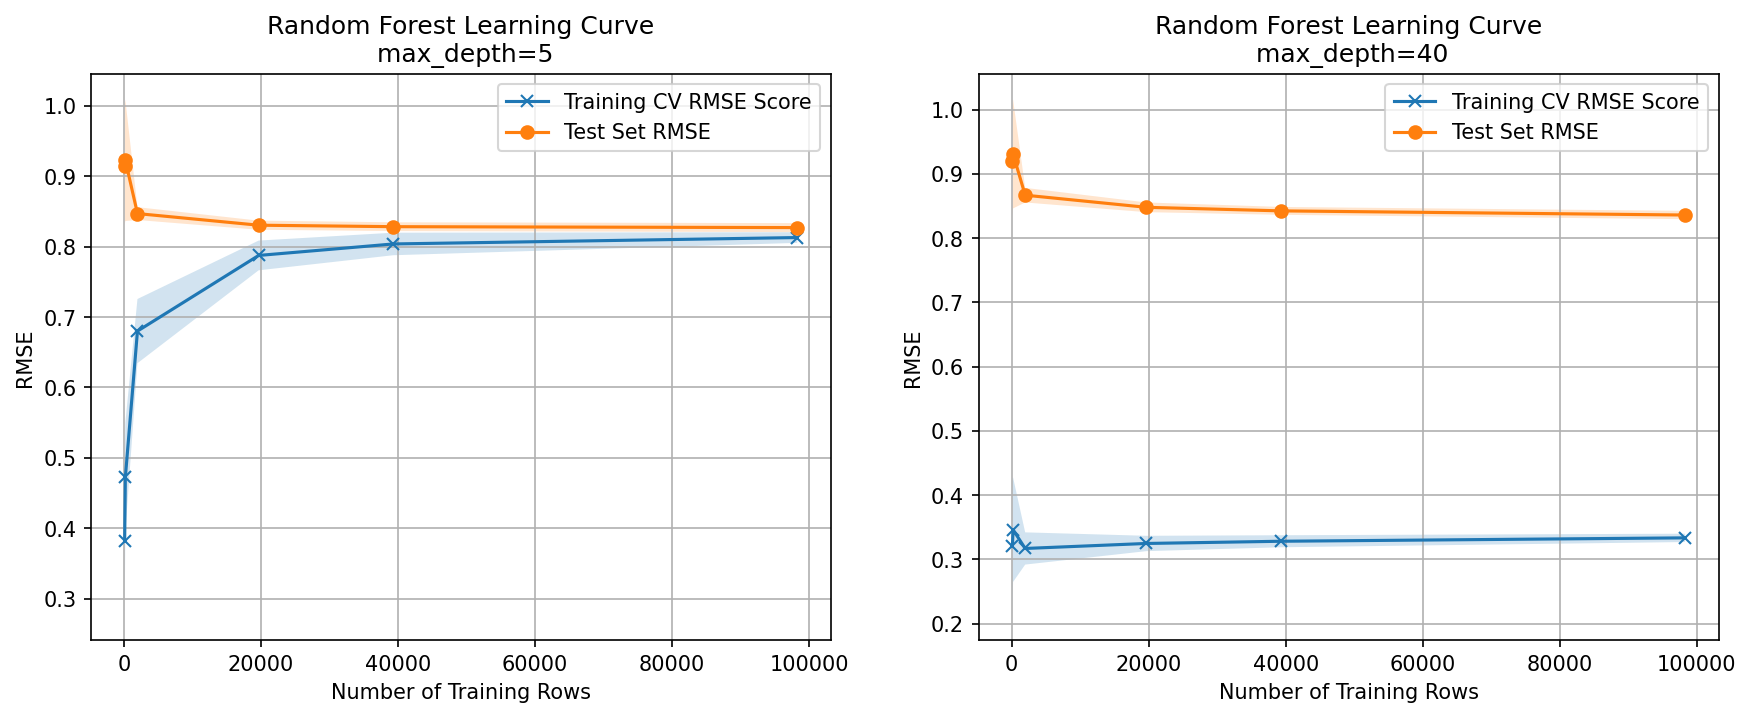

In [47]:
rf_regr = RandomForestRegressor(random_state=2, max_depth=5)
rf_df1 = cvLearnCurvesScores(rf_regr, X, y)
rf_regr = RandomForestRegressor(random_state=2, max_depth=40)
rf_df2 = cvLearnCurvesScores(rf_regr, X, y)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plotCurves(rf_df1,'Random Forest Learning Curve\n max_depth=5')
plt.subplot(1,2,2)
plotCurves(rf_df2,'Random Forest Learning Curve\n max_depth=40')

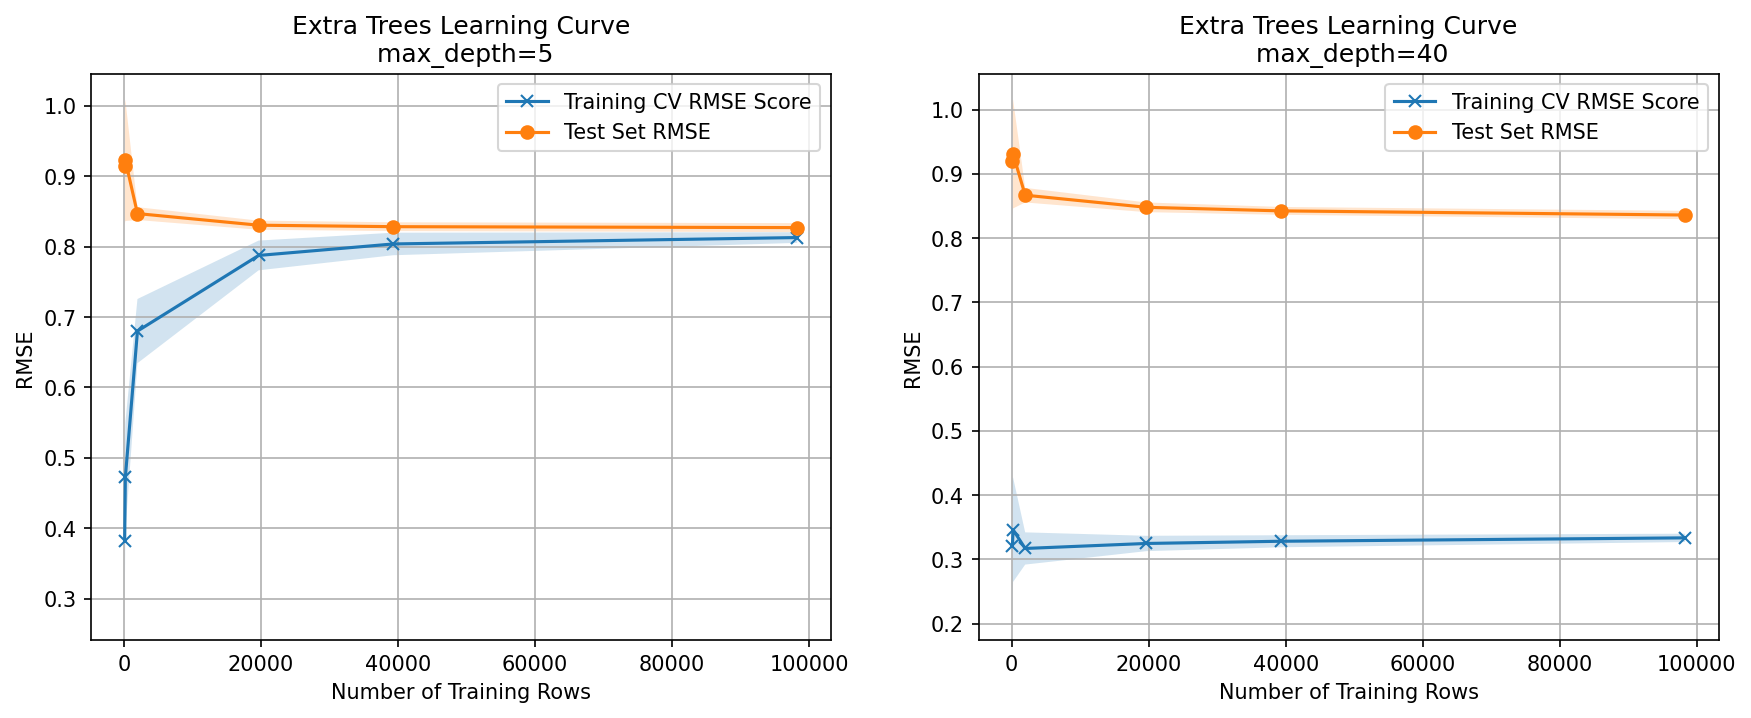

In [48]:
ert_regr = RandomForestRegressor(random_state=2, max_depth=5)
ert_df1 = cvLearnCurvesScores(ert_regr, X, y)
ert_regr = RandomForestRegressor(random_state=2, max_depth=40)
ert_df2 = cvLearnCurvesScores(ert_regr, X, y)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plotCurves(rf_df1,'Extra Trees Learning Curve\n max_depth=5')
plt.subplot(1,2,2)
plotCurves(rf_df2,'Extra Trees Learning Curve\n max_depth=40')

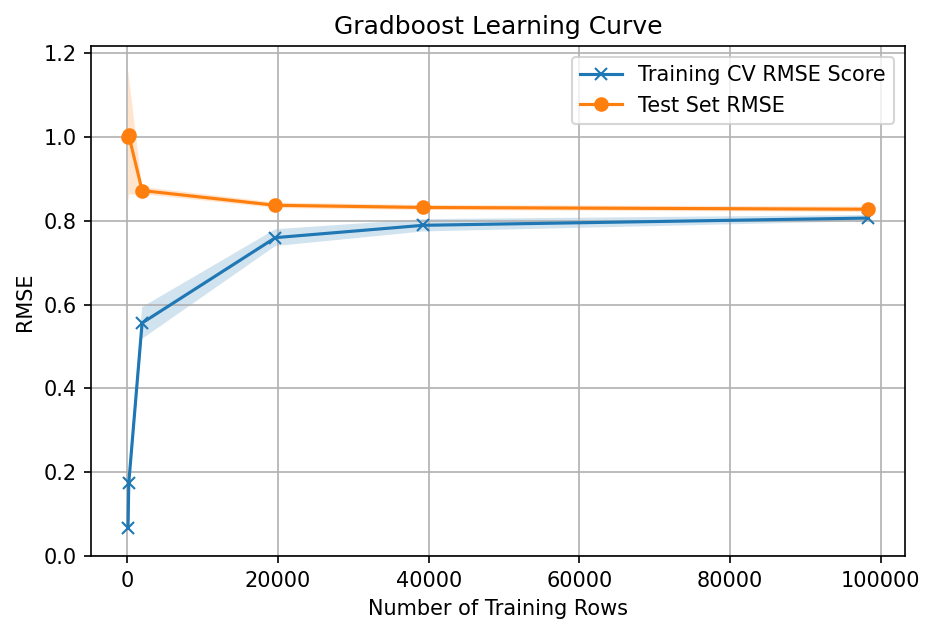

In [49]:
gbst_df = cvLearnCurvesScores(gbst_regr, X, y)
plotCurves(gbst_df,'Gradboost Learning Curve')